In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [2]:
W_list = [1,10,20,30,40]
filename_list = np.genfromtxt('./20230804_desmearedData/FileNames.txt',dtype='str')

In [3]:
import os
n_des = 1
## load desmeared D22 data
data_path = './20230804_desmearedData/'
data_list = []
data_list_6 = []
for i in range(5):
    filename = '{}_des{}.txt'.format(6+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)

    filename = '{}_des{}.txt'.format(1+i,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list_6.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

In [4]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

## Plot data

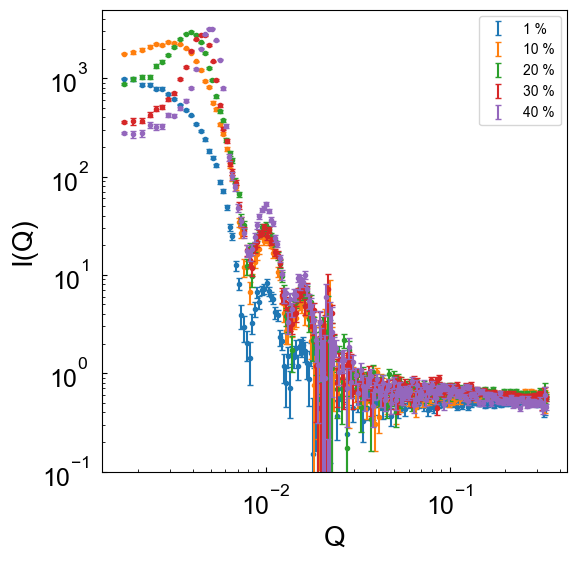

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = ['C0','C1','C2','C3','C4']
for i, W in enumerate(W_list):
    dataname = '{} %'.format(W)
    data = data_list[i]
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i] ,capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_ylim([0.1,5000])
ax.set_xlabel('Q',fontsize=20)
ax.set_ylabel('I(Q)',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()
plt.show()

## Define function

In [6]:
def hardsphere(q, sigma=1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2
    return P

def fuzzysphere(q, sigma=1, sigma_f=0.1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2 * np.exp(-(sigma_f * sigma * q) ** 2 / 2)
    return P

def log_normal_pdf(mu, sigma, x):
    return np.exp(-(np.log(x) - mu) ** 2 / 2 / sigma ** 2) / x / sigma

def P_HS_eff(q, sigma=1, d_sigma=0.05, return_f=False):
    '''
    sigma: average particle size
    d_sigma: polydispersity
    return_f: toggle whether to return the particle size distribution
    '''
    # List of particle diameter
    n_sample = 101
    sigma_list = (1 + np.linspace(-5, 5, n_sample) * d_sigma) * sigma
    sigma_list = sigma_list[sigma_list > 0]

    # Size distribution
    f_sigma = log_normal_pdf(0, d_sigma, sigma_list / sigma)
    p_sigma = f_sigma * (sigma_list / sigma) ** 6

    # Calculate effective P(Q)
    P_eff = np.zeros_like(q)
    for i in range(len(sigma_list)):
        P_i = hardsphere(q, sigma_list[i]) * p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff / np.sum(p_sigma)

    if return_f:
        return P_eff, sigma_list, f_sigma
    else:
        return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''

    Qmean = Q
    N = len(Q)
    IQ = []

    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1 / np.sqrt(2 * np.pi * current_dQ ** 2)) * np.exp(-(Q_fine - current_Qmean) ** 2 / (2 * current_dQ ** 2))
        IQ_resoln = IQ_th * w_gauss

        IQ.append(np.trapz(IQ_resoln, Q_fine) / np.trapz(w_gauss, Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out  # sampled on Q

def I_P(Q, dQ, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q, sigma=sigma, d_sigma=d_sigma)
    Q_fine = Q
    P_res = IQ_resoln(Q, Q_fine, P, dQ)
    f_interp = interp.interp1d(Q_fine, P_res, fill_value='extrapolate')
    P = f_interp(Q)

    return A * P + I_inc

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q, sigma=sigma, d_sigma=d_sigma)

    return A * P + I_inc


## Fit form factor

In [7]:
# 1%
data = data_list[0]
Q, IQ, IQ_er = unpack_data(data)
IQ_P = IQ
IQ_er_P = IQ_er

# remove extreme values
index_extreme = IQ<0.4
Q = np.delete(Q,index_extreme)
IQ = np.delete(IQ,index_extreme)
IQ_er = np.delete(IQ_er,index_extreme)

# initialize parameters
params = Parameters()
params.add('sigma', value=1500, min=1100, max=1300)
params.add('A', value=1e3, min=5e2, max=1.5e3)
params.add('I_inc', value=0.8, min=0.5, max=1)
params.add('d_sigma', value=0.08, min=0.005, max=0.15)

index_Q = (Q>1e-3)*(Q<5e-1)
# loss function for fitting form factor
def lambda_P(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])) 
           - (IQ_exp))/IQ_er**2)[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_P, params, fcn_args=(Q, IQ, index_Q))
result_P = minner.minimize(method='nelder')

# fitted curve
v = result_P.params.valuesdict()
IQ_fit = I_P_d(Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])

# write error report
report_fit(result_P)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 657
    # data points      = 186
    # variables        = 4
    chi-square         = 122114.166
    reduced chi-square = 670.956954
    Akaike info crit   = 1214.57549
    Bayesian info crit = 1227.47848
[[Variables]]
    sigma:    1151.43470 +/- 80.6915498 (7.01%) (init = 1300)
    A:        1218.17789 +/- 582.614096 (47.83%) (init = 1000)
    I_inc:    0.50833782 +/- 0.00182264 (0.36%) (init = 0.8)
    d_sigma:  0.06085888 +/- 0.06643251 (109.16%) (init = 0.08)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, d_sigma) = -0.4113
    C(sigma, A)       = +0.3687


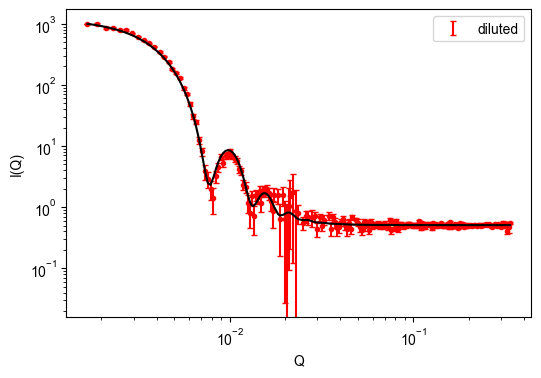

In [8]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.r')
ax.errorbar(Q,IQ,IQ_er,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q[index_Q],IQ_fit,'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 178
    # variables        = 2
    chi-square         = 65841.8179
    reduced chi-square = 374.101238
    Akaike info crit   = 1056.55439
    Bayesian info crit = 1062.91795
[[Variables]]
    A:      4435.32004 +/- 1886.80851 (42.54%) (init = 10000)
    I_inc:  0.59690687 +/- 0.00317112 (0.53%) (init = 0.5)


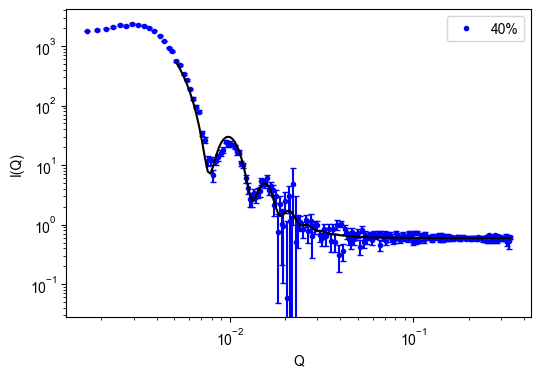

In [9]:
# 10%
data = data_list[1]
Q, IQ, IQ_er = unpack_data(data)
IQ_I = IQ
IQ_er_I = IQ_er

# # remove extreme values
# index_extreme = (Q>0.022) & (Q<0.023)
# Q = np.delete(Q,index_extreme)
# IQ = np.delete(IQ,index_extreme)
# IQ_er = np.delete(IQ_er,index_extreme)

# loss function for fitting form factor
def lambda_I(params, Q, IQ_exp, index_Q):
    v = params.valuesdict()
    return (((I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
           - (IQ_exp))/IQ_er**2)[index_Q]

sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=1e4, min=2e2, max=2e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q>5e-3)*(Q<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q, IQ, index_Q))
result_I = minner.minimize()

# fitted curve
v = result_I.params.valuesdict()
IQ_fit = I_P_d(Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)

# write error report
report_fit(result_I)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.b',label='{}%'.format(W))
ax.errorbar(Q,IQ,IQ_er,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q],IQ_fit[index_Q],'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_24996\4072754958.py:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,20])


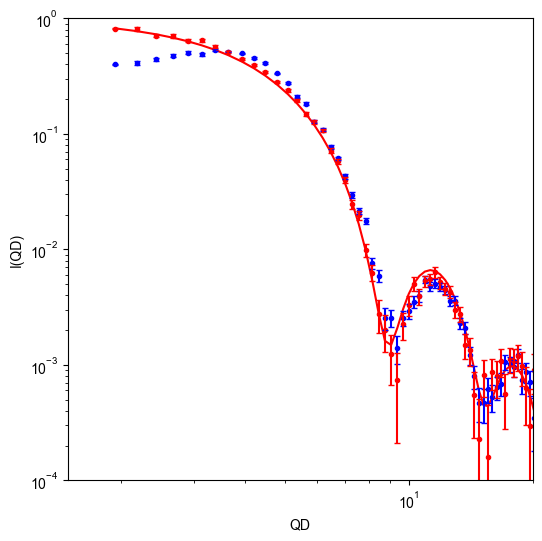

In [10]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_P_scaled = (IQ_P-fp_opt_P['I_inc'])/fp_opt_P['A']
IQ_I_scaled = (IQ_I-fp_opt_I['I_inc'])/fp_opt_I['A']
IQ_er_P_scaled = (IQ_er_P)/fp_opt_P['A']
IQ_er_I_scaled = (IQ_er_I)/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q*fp_opt_P['sigma'],IQ_I_scaled,'.b')
ax.plot(Q*fp_opt_P['sigma'],IQ_P_scaled,'.r')
ax.plot(Q*fp_opt_P['sigma'], I_P_d(Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-r')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I_scaled,IQ_er_I_scaled,
            linestyle='',color='b',capsize=2)
ax.errorbar(Q*fp_opt_P['sigma'],IQ_P_scaled,IQ_er_P_scaled,
            linestyle='',color='r',capsize=2)


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,20])
ax.set_ylim([1e-4,1])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
# ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_24996\366021770.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,20])
C:\Users\wagen\AppData\Local\Temp\ipykernel_24996\366021770.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,3])


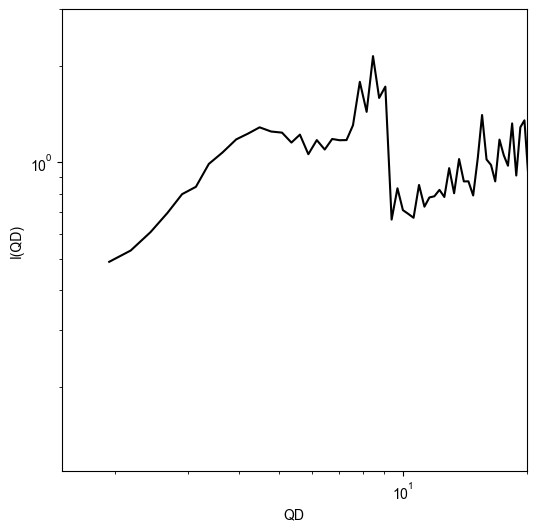

In [11]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q*fp_opt_P['sigma'], 
        IQ_0/I_P_d(Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,20])
ax.set_ylim([0,3])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
plt.show()

## Fit structure factor

In [12]:
'''
convert the input data to the same 80-D array as SQ-NN model
Q: Experimental scattering vector 
q: Rescaled Q
sq_dim: Dimension of rescaled q
'''
## Interpolate data
sq_dim = 80
sample_dim = 1
q = (np.arange(sq_dim)+1)*0.2

## The input data is rescaled to the range such that 0.02<=QD<=16 
r_HS_i = fp_opt_P['sigma']/2 # from form factor fitting
d_HS_i = r_HS_i*2
print('Initial guess of d_HS = {}'.format(d_HS_i))
IQ_rs = np.zeros((sample_dim,sq_dim)) 
Qd_HS = Q*d_HS_i

## rescale IQ to QD in [0,16]
f_IQ = interp.interp1d(Qd_HS,IQ_I,fill_value='extrapolate')
IQ_rs = f_IQ(q).astype(np.float64)
IQ_rs[IQ_rs<=0] = 1e-5

## rescale IQ_er to QD in [0,16]
f_IQ_er = interp.interp1d(Qd_HS,IQ_er_I,fill_value='extrapolate',kind='nearest')
IQ_er_rs = f_IQ_er(q).astype(np.float64)
# IQ_er_rs[IQ_er_rs<=0] = 1e-5

Initial guess of d_HS = 1151.4347035441897


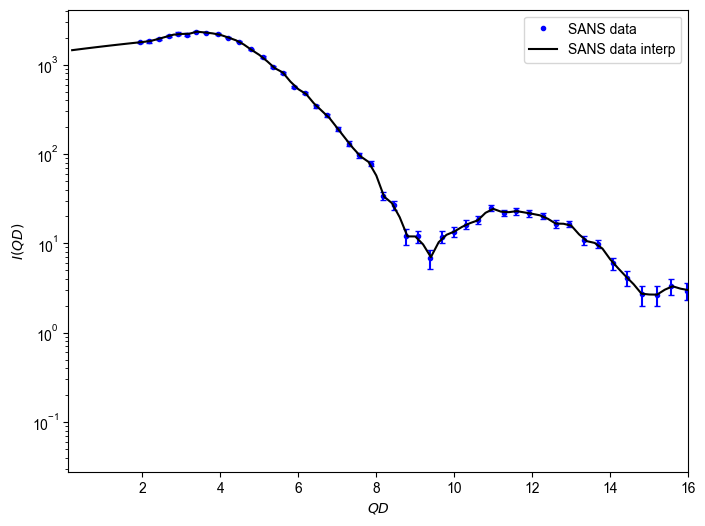

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*fp_opt_P['sigma'],IQ_I,'.b',label='SANS data')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I,IQ_er_I,linestyle='',color='b',capsize=2)
ax.plot(q,IQ_rs,'-k',label='SANS data interp')
ax.set_xlim([0.1,16])
# ax.set_ylim([0.1,30])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

In [14]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=1)

In [15]:
def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],v['A'],1]

    # structure factor
    S = SQ_NN(fp[0:3])
    S = savgol_filter(S,7,2)

    # form factor
    P = P_HS_eff(Q,sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*P*S + v['I_inc']
    return I

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (x-y)/z
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])

## evaluate uncertainty
def cov_fp(v, IQ_rs, IQ_er_rs, index_Q):
    delta = 0.05
    x_list = 1 + np.linspace(-5,5,7)*delta
    phi_list = x_list*v['phi']
    kappa_list = x_list*v['kappa']
    A_list = x_list*v['A']
    fp_center = [v['phi'],v['kappa'],v['A']]
    phi_grid, kappa_grid, A_grid = np.meshgrid(phi_list, kappa_list, A_list)
    phi_flat = phi_grid.flatten(order='C')
    kappa_flat = kappa_grid.flatten(order='C')
    A_flat = A_grid.flatten(order='C')
    fp_flat_list = [phi_flat,kappa_flat,A_flat]

    def IQ_fp(fp):
        # structure factor
        S = SQ_NN(fp[0:3])
        S = savgol_filter(S,7,2)

        # form factor
        P = P_HS_eff(q,sigma=v['sigma'], d_sigma=v['d_sigma'])

        I = v['C']*P*S + v['I_inc']
        return I

    # calculate likelihood
    likelihood_flat = np.zeros_like(phi_flat)
    for i in np.arange(len(phi_flat)):
        index = np.unravel_index(i, phi_grid.shape)
        fp = [phi_flat[i], kappa_flat[i], A_flat[i]]
        IQ = IQ_fp(fp)
        minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/z)**2))
        likelihood_flat[i] = minimizer_target(IQ[index_Q],IQ_rs[index_Q],IQ_er_rs[index_Q])

    # calculate covariance matrix
    cov = np.zeros([3,3])
    for m in range(3):
        for n in range(3):
            d_m = fp_flat_list[m]-fp_center[m]
            d_n = fp_flat_list[n]-fp_center[n]
            cov[m,n] = np.sum(likelihood_flat*d_m*d_n)/np.sum(likelihood_flat)

    return cov

In [16]:
# initialize parameters
params = Parameters()
params.add('C', value=4100, min=4000, max=5000)
params.add('I_inc', value=0.5, min=0.55, max=2)
params.add('sigma', value=0.975, min=0.9, max=1.1)
params.add('d_sigma', value=0.07, min=0.05, max=0.1)

fp_i =       [0.08, 0.15,  11]
fp_ubounds = (0.5,  0.18,  20)
fp_lbounds = (0.05, 0.1,  0.5)
fp_name = ['phi', 'kappa', 'A']
for i in range(3):
    params.add(fp_name[i], value=fp_i[i], min=fp_ubounds[i], max=fp_lbounds[i])

# do fit, here with the nelder algorithm
index_Q = (q>2)*(q<16)
minner = Minimizer(lmbda, params, fcn_args=(q, IQ_rs, IQ_er_rs, index_Q))
result = minner.minimize(method='nelder')

# write error report
report_fit(result)


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1042
    # data points      = 69
    # variables        = 7
    chi-square         = 358.394549
    reduced chi-square = 5.78055724
    Akaike info crit   = 127.679430
    Bayesian info crit = 143.318175
[[Variables]]
    C:        4532.34951 +/- 75.7371294 (1.67%) (init = 4100)
    I_inc:    0.55368856 +/- 0.02617037 (4.73%) (init = 0.55)
    sigma:    0.97663859 +/- 0.00455766 (0.47%) (init = 0.975)
    d_sigma:  0.06836241 +/- 0.00650779 (9.52%) (init = 0.07)
    phi:      0.06942919 +/- 2.5581e-05 (0.04%) (init = 0.08)
    kappa:    0.15010815 +/- 1.7248e-05 (0.01%) (init = 0.15)
    A:        11.2962535 +/- 0.00707890 (0.06%) (init = 11)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi, kappa)     = +15.5832
    C(phi, A)         = +9.7495
    C(kappa, A)       = -5.8584
    C(sigma, d_sigma) = -0.5354
    C(C, d_sigma)     = +0.3822
    C(C, sigma)       = +0.3704
    C(C, phi)       

In [17]:
## extend S(Q) and I(Q)
q = (np.arange(sq_dim)+1)*0.2
q_ext = (np.arange(200)+1)*0.2

def extend_SQ(q_ext, SQ, decay=1):
    f = interp.interp1d(q,SQ,fill_value='extrapolate',kind='linear')
    SQ_ext = f(q_ext)
    # decay to asymptote value
    delta_ext = SQ_ext-1
    center = q[-1]
    W = 1-(np.tanh(decay*(q_ext-center))+1)/2
    SQ_ext = delta_ext*W + 1

    return SQ_ext

def IQ_th_ext(params, Q_ext):
    v = params.valuesdict()
    fp = [v['phi'],v['kappa'],v['A'],1]

    # structure factor
    S = SQ_NN(fp[0:3])
    S = savgol_filter(S,7,2)

    S_ext = extend_SQ(Q_ext, S, decay=1)

    # form factor
    P = P_HS_eff(Q_ext,sigma=v['sigma'], d_sigma=v['d_sigma'])

    I = v['C']*P*S_ext + v['I_inc']
    return I

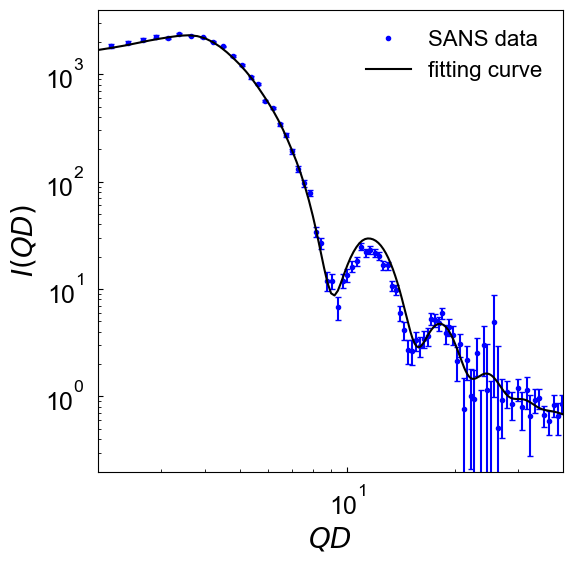

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

ax.plot(Q*fp_opt_P['sigma'],IQ_I,'.b',label='SANS data')
ax.errorbar(Q*fp_opt_P['sigma'],IQ_I,IQ_er_I,linestyle='',color='b',capsize=2)
# ax.plot(q[index_Q], IQ_th(params,q)[index_Q],'--k',label='initial guess')
# ax.plot(q[index_Q], IQ_th(result.params,q)[index_Q],'-k',label='fitting curve')

## extend S(Q)
ax.plot(q_ext, IQ_th_ext(result.params,q_ext),'-k',label='fitting curve')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([2,40])
ax.set_ylim([0.2,4000])
ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=16,frameon=False)
plt.show()

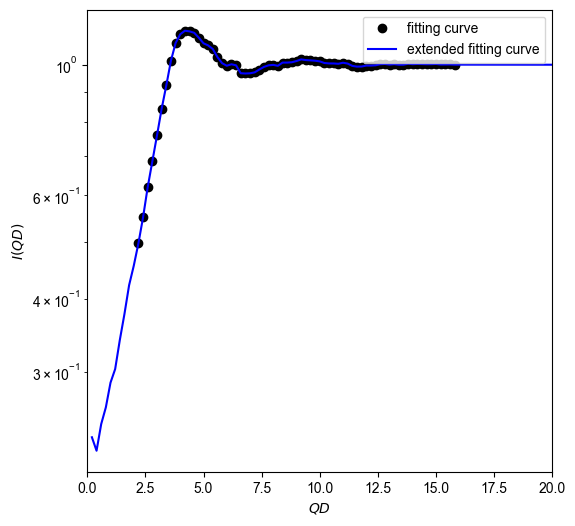

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# # initial guess S(Q)
# v = params.valuesdict()
# fp = [v['phi'],v['kappa'],v['A'],1]
# ax.plot(q[index_Q], SQ_NN(fp)[index_Q],'--k',label='initial guess')

# optimized S(Q)
v = result.params.valuesdict()
fp = [v['phi'],v['kappa'],v['A'],1]
ax.plot(q[index_Q], SQ_NN(fp)[index_Q],'ok',label='fitting curve')

# extended S(Q)
v = result.params.valuesdict()
fp = [v['phi'],v['kappa'],v['A'],1]
SQ_ext = extend_SQ(q_ext, SQ_NN(fp), decay=1)
ax.plot(q_ext, SQ_ext,'-b',label='extended fitting curve')

ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim([0,20])
# ax.set_ylim([2,3000])
ax.set_xlabel(r'$QD$')
ax.set_ylabel(r'$I(QD)$')
ax.legend()
plt.show()

In [20]:
def Z(A,kappa):
    return np.sqrt(A*(1+1/2/kappa)**2)   
def Z_err(A,kappa,A_err,kappa_err,delta = 1e-3):
    dZ_dA = (Z(A*(1+delta),kappa)-Z(A,kappa))/(A*delta)
    dZ_dkappa = (Z(A,kappa*(1+delta))-Z(A,kappa))/(kappa*delta)
    
    Z_err = np.sqrt((dZ_dA*A_err)**2 + (dZ_dkappa*kappa_err)**2)
    return Z_err

epsilon_0 = 8.854e-12 # Vacuum_permittivity (F*m^-1 = Columb^2 J^-1 m^-1)
epsilon_water = 80.4*epsilon_0 #  Water permittivity @ 20 degree C
epsilon_glycerol = 47*epsilon_0 #  Glycerol permittivity @ 20 degree C
e = 1.60217663e-19 # Electron charge (Columb)
kB = 1.380649e-23 # Boltzmann constant (J/K)
sigma = fp_opt_P['sigma']*1e-10 # Particle diameter (m)
Z_0 = np.sqrt((kB*293*sigma)*epsilon_glycerol/e**2)

In [21]:
v = result.params.valuesdict()
cov = cov_fp(v, IQ_rs, IQ_er_rs, index_Q)
fp = [v['phi'],v['kappa'],v['A']]
fp_std = np.sqrt(np.diag(cov))
fp_Z = Z(fp[2],fp[1])*Z_0
fp_std_Z = Z_err(fp[2],fp[1],fp_std[2],fp_std[1])*Z_0
print('phi   = {:0.4f} +- {:0.4f}'.format(fp[0],fp_std[0]))
print('kappa = {:0.4f} +- {:0.4f}'.format(fp[1],fp_std[1]))
print('A     = {:0.4f} +- {:0.4f}'.format(fp[2],fp_std[2]))
print('Z     = {:0.4f} +- {:0.4f}'.format(fp_Z,fp_std_Z))

phi   = 0.0694 +- 0.0072
kappa = 0.1501 +- 0.0223
A     = 11.2963 +- 1.8789
Z     = 39.9993 +- 5.6527


In [24]:
## save_fitting results
IQ_fit_P = I_P_d(q_ext/fp_opt_P['sigma'], fp_opt_P['sigma'], fp_opt_P['A'], fp_opt_P['I_inc'], fp_opt_P['d_sigma'])

filename = 'results_10.mat'
mdic = {'Q':Q, 'IQ_I':IQ_I, 'IQ_er_I':IQ_er_I,
        'IQ_P':IQ_P, 'IQ_er_P':IQ_er_P, 'IQ_fit_P':IQ_fit_P,
        'q_ext':q_ext, 'IQ_ext':IQ_th_ext(result.params,q_ext),
        'sigma':sigma, 'fp':fp, 'fp_std':fp_std, 'fp_Z':fp_Z, 'fp_std_Z':fp_std_Z}
savemat(filename,mdic)